In [1]:
%load_ext autoreload
%autoreload 2
from glob import glob
from torch.utils.data import DataLoader
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
from tqdm import tqdm
from monai.data import CacheDataset, Dataset, list_data_collate
from monai.transforms import (
    AsChannelFirstd,
    AddChanneld,
    AsDiscreted,
    Compose,
    CropForegroundd,
    EnsureChannelFirstd,
    LoadImaged,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    RandRotated,
    RandZoomd,
    Rotated,
    ScaleIntensityd,
    ScaleIntensityRanged,
    ThresholdIntensityd,
    Transposed,
    EnsureTyped,
    RandAffined,
    Transform,
    MapTransform,
    RandGibbsNoised,
    RandKSpaceSpikeNoised,
    RandGaussianNoised,
    RandCoarseDropoutd,
    ResizeWithPadOrCropd,
    RandSpatialCropd,
    Lambdad
)

# ensure is in parent directory
try:
    print(os.getcwd())
    os.chdir("../../rug-hr/")
    print(os.getcwd())
except:
    pass

c:\Users\mo\Documents\Organisations\RUG\rug-hr\experiments
c:\Users\mo\Documents\Organisations\RUG\rug-hr


## Experiment setup

In [2]:
SPATIAL_SIZE = [128, 1024]
SPATIAL_ALIAS = "x".join([str(x) for x in SPATIAL_SIZE])
VERSION = "v1"
ALIAS = "iam"
MODEL_OUTPUT_NAME = f"seglm-masked-{VERSION}-{SPATIAL_ALIAS}-{ALIAS}.pt"

config = {
    "epochs": 200,
    "batch_size": 12,
    "learning_rate": 1e-4,
    "architecture": "UNETR",
    "dataset": "handwitten_manuscripts",
    "spatial_size": SPATIAL_SIZE,
    "splits": [0.88, 0.08],
    "model_output_name": MODEL_OUTPUT_NAME,
    "name": "IAM handwriting recognition",
    "description": "Masked language model for handwriting recognition",
    "pretrained_model": MODEL_OUTPUT_NAME,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
}

# print summary
print("Configuration:")
print("Output model name: ", config["model_output_name"])
print("Using model: ", config["architecture"])
print("Using dataset: ", config["dataset"])
print("Using spatial size: ", config["spatial_size"])
print("Using splits: ", config["splits"])
print("Using learning rate: ", config["learning_rate"])
print("Using batch size: ", config["batch_size"])
print("Using epochs: ", config["epochs"])
print("Using pretrained model: ", config["pretrained_model"])

Configuration:
Output model name:  seglm-masked-v1-128x1024-iam.pt
Using model:  UNETR
Using dataset:  handwitten_manuscripts
Using spatial size:  [128, 1024]
Using splits:  [0.88, 0.08]
Using learning rate:  0.0001
Using batch size:  12
Using epochs:  200
Using pretrained model:  seglm-masked-v1-128x1024-iam.pt


In [3]:
import wandb 
def init_experiment(config=config):
    wandb.init(
        project="handwriting-recognition-iam",
        config=config,
    )

def terminate_experiment():
    wandb.finish()

def log(data):
    wandb.log(data)

## Data setup

Some notes:
- Max height: 342; Max width: 2260
- Min height: 44; Min width: 100
- Mean height: 121.56060606060606; Mean width: 1693.719093590775
- Max tokens: 27

In [4]:
dataset_name = config["dataset"]
segs = glob(f"./datasets/{dataset_name}/Raw/*")
imgs = glob(f"./datasets/{dataset_name}/Mutated/*")
fraction = 1

metadata = [{
    "img": p_img, 
    "seg": p_seg, 
} for p_img, p_seg in zip(imgs, segs)]

random.shuffle(metadata)
metadata = metadata[:int(len(metadata) * fraction)]

# split into training, validation and test set
split_train = int(len(metadata) * config["splits"][0])
split_validation = int(len(metadata) * (config["splits"][1] + config["splits"][0]))

train_metadata = metadata[:split_train]
validation_metadata = metadata[split_train:split_validation]
test_metadata = metadata[split_validation:]

print(f"Train: {len(train_metadata)}; Validation: {len(validation_metadata)}; Test: {len(test_metadata)}")
print(f"Example: {train_metadata[0]}")
n_classes = ord("~") - ord(" ") + 1
print(f"Number of classes: {n_classes}")

Train: 23254; Validation: 2114; Test: 1057
Example: {'img': './datasets/handwitten_manuscripts/Mutated\\41785_Alex Brush_118.png', 'seg': './datasets/handwitten_manuscripts/Raw\\41785_Alex Brush_118.png'}
Number of classes: 95


In [5]:

from monai.config import KeysCollection


class Invert(Transform):
    def __call__(self, data, max_value=1.0, min_value=0.0):
        return max_value - data + min_value

class Invertd(MapTransform):
    def __init__(self, keys):
        super().__init__(keys)
        self.invert = Invert()

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            d[key] = self.invert(d[key])
        return d
    
class AddMask(Transform):
    """ Adds a mask channel to the image where 
    Args: 
        prob: probability of zeroing out a region
        min_portion: minimum portion of the image to zero out in each dimension
        max_portion: maximum portion of the image to zero out in each dimension
    """
    def __init__(self, 
                 prob=0.5, 
                 min_portion=(0.1, 0.1), 
                 max_portion=(0.5, 0.5)):
        self.prob = prob
        self.min_portion = min_portion
        self.max_portion = max_portion
    
    """
    Args:
        image: (..., C, H, W)
    Returns: with mask channel added
        image: (..., C+1, H, W)
    """
    def __call__(self, image):
        C, H, W = image.shape[-3:]
        mask = torch.ones((*image.shape[:-3], 1, H, W))
        if random.random() < self.prob:
            min_p_i, min_p_j = self.min_portion
            max_p_i, max_p_j = self.max_portion
            p_i = random.uniform(min_p_i, max_p_i)
            p_j = random.uniform(min_p_j, max_p_j)
            size_i = int(H * p_i)
            size_j = int(W * p_j)
            i_start = random.randint(0, H - size_i)
            j_start = random.randint(0, W - size_j)
            i_end = i_start + size_i
            j_end = j_start + size_j   
            mask[..., i_start:i_end, j_start:j_end] = 0
        image *= mask
        return torch.cat([image, mask], dim=-3)
    
class AddMaskd(MapTransform):
    def __init__(self, keys: KeysCollection, allow_missing_keys: bool = False,  *argc, **argv) -> None:
        super().__init__(keys, allow_missing_keys)
        self.add_mask = AddMask(*argc, **argv)
    
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            d[key] = self.add_mask(d[key])
        return d

augmentation_transforms = Compose([
    RandCoarseDropoutd(keys=["img"], holes=128, spatial_size=(8, 8), max_holes=128, fill_value=0, prob=0.5),
    RandGaussianNoised(keys=["img"], mean=0.0, std=0.02, prob=0.7),
    RandShiftIntensityd(keys=["img"], offsets=0.1, prob=0.5),
])

input_transforms = Compose([
    # Image transformations
    LoadImaged(keys=["img", "seg"]),
    AddChanneld(keys=["img", "seg"]),
    EnsureTyped(keys=["img", "seg"]),
    Transposed(keys=["img", "seg"], indices=[0, -1, -2]),
    CropForegroundd(keys=["img", "seg"], source_key="img", ),
    ResizeWithPadOrCropd(
        keys=["img", "seg"],
        spatial_size=(256, 2048),
        mode="constant",
    ),
    ScaleIntensityRanged(keys=["img"], a_min=0, a_max=1, b_min=0.0, b_max=1.0, clip=True),
    # Augmentation
    augmentation_transforms,
    # Post processing
    ScaleIntensityRanged(keys=["img"], a_min=0, a_max=1, b_min=0.0, b_max=1.0, clip=True),
    AddMaskd(
        keys=["img"], 
        prob=1.0, 
        min_portion=(0.8, 0.01), 
        max_portion=(0.9, 0.05),
    ),
    RandSpatialCropd(
        keys=["img", "seg"],
        roi_size=config["spatial_size"],
        random_size=False,
    ),
    Lambdad(keys=["seg"], func=lambda x: torch.clamp(x, 0, n_classes-1)),
    EnsureTyped(keys=["img", "seg"]),
])

train_transforms = Compose([
    input_transforms,
    EnsureTyped(keys=["img", "seg"]),
])

validation_transforms = Compose([
    input_transforms,
    EnsureTyped(keys=["img", "seg"]),
])


c:\Users\mo\anaconda3\envs\ml_env\lib\site-packages\monai\utils\deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)


image: torch.Size([2, 128, 1024])
segmentation: torch.Size([1, 128, 1024])
range(img): (tensor(0.), tensor(1.))
range(img[1]): (tensor(0.), tensor(1.))
range(seg): (tensor(0.), tensor(89.))


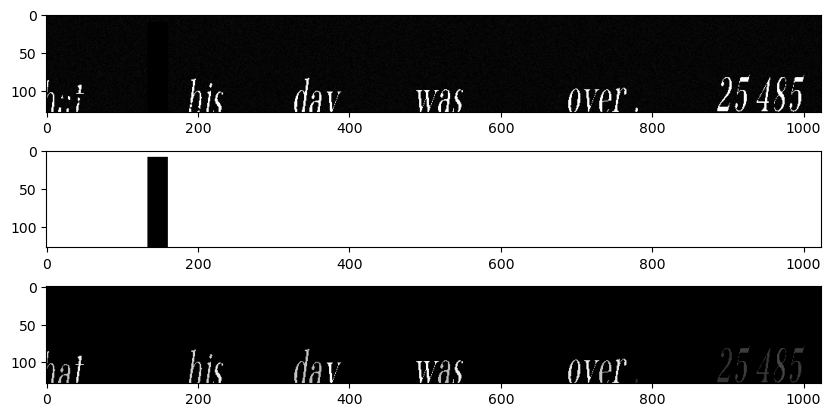

In [6]:

# example
choice = random.choice(train_metadata)
output = train_transforms(choice)
spatial_size = torch.zeros(config["spatial_size"]).shape
assert output["img"][0].shape == spatial_size or print(output["img"][0].shape, spatial_size)
assert output["seg"][0].shape == spatial_size or print(output["seg"][0].shape, spatial_size)
# ensuer seg is at max n_classes
assert output["seg"].max() < n_classes or print("wrong seg max", output["seg"].max())
assert output["seg"].min() >= 0 or print("wrong seg min", output["seg"].min())
assert output["img"].max() <= 1 or print("wrong img max", output["img"].max())
assert output["img"].min() >= 0 or print("wrong img min", output["img"].min())
assert output["img"].shape[0] == 2 or print(output["img"].shape)
assert output["seg"].shape[0] == 1 or print(output["seg"].shape)

 
print("image:", output["img"].shape)
print("segmentation:", output["seg"].shape)
print(f"range(img): ({output['img'].min()}, {output['img'].max()})")
print(f"range(img[1]): ({output['img'][1].min()}, {output['img'][1].max()})")
print(f"range(seg): ({output['seg'].min()}, {output['seg'].max()})")
fig, ax = plt.subplots(3, 1, figsize=(10, 5))
ax[0].imshow(output["img"][0], cmap="gray")
ax[1].imshow(output["img"][1], cmap="gray")
ax[2].imshow(output["seg"][0], cmap="gray")
plt.show()

In [7]:
train_dataset = CacheDataset(data=train_metadata, transform=train_transforms)
validation_dataset = CacheDataset(data=validation_metadata, transform=validation_transforms)
test_dataset = Dataset(data=test_metadata, transform=input_transforms)
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"])
validation_loader = DataLoader(validation_dataset, batch_size=config["batch_size"])
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"])

Loading dataset: 100%|██████████| 2114/2114 [00:00<00:00, 2115666.58it/s]


In [8]:

from modules.segnet import SEGNET
from monai.networks.nets import UNETR

print("device name", torch.cuda.get_device_name(0))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

model_output_name = config.get("model_output_name")

hidden_size = 768
model = UNETR(
    in_channels=2,
    out_channels=n_classes, 
    img_size=config["spatial_size"],
    feature_size=32,
    num_heads=12,
    hidden_size=hidden_size,
    mlp_dim=4*hidden_size,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.1,
    spatial_dims=2,
    conv_block=False
).to(device)

net = SEGNET(
    model_name=model_output_name,
    device=device, 
    load=False,
    model=model,
    img_size=config["spatial_size"],
    n_classes=n_classes,
)

pre_trained_model = config.get("pretrained_model", None)
if pre_trained_model:
    try:
        net.load_model("artifacts/" + pre_trained_model)
        print("model loaded")
    except:
        print("could not load model")

# print number of trainable parameters
print("number of trainable parameters in millions:", sum(p.numel() for p in model.parameters() if p.requires_grad) / 1000000)
print("model size (MB)", sum(p.numel() for p in model.parameters() if p.requires_grad) * 4 / 1024 / 1024)

device name NVIDIA GeForce RTX 3090
model loaded
number of trainable parameters in millions: 90.785727
model size (MB) 346.32006454467773


In [9]:
init_experiment(config)

train_loss, test_loss, metrics = net.train(
    trainloader=train_loader, 
    valloader=validation_loader,
    log=log, 
    epochs=config.get("epochs"), 
    learning_rate=config.get("learning_rate"), 
    optimizer_name="adam", 
    schedule=False,
)

terminate_experiment()

2023-05-28 23:10:27,504 - Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: massaf (rug-ai-group). Use `wandb login --relogin` to force relogin


epochs=200; N=23254; batches=1938; learning_rate=0.0001


100%|██████████| 1938/1938 [30:43<00:00,  1.05it/s]


epoch 1/200; train_loss=0.2679738558067626; test_loss=0.2683675202441081; lr=0.0001; metric=0.8693407773971558


100%|██████████| 1938/1938 [27:39<00:00,  1.17it/s]


epoch 2/200; train_loss=0.2676601887779585; test_loss=0.26985224963581494; lr=0.0001; metric=0.8719177842140198


100%|██████████| 1938/1938 [25:49<00:00,  1.25it/s]


epoch 3/200; train_loss=0.26667958815554227; test_loss=0.2738406880427215; lr=0.0001; metric=0.8639684915542603


100%|██████████| 1938/1938 [25:16<00:00,  1.28it/s]


epoch 4/200; train_loss=0.265961676074809; test_loss=0.2730033886803072; lr=0.0001; metric=0.8662654757499695


100%|██████████| 1938/1938 [25:07<00:00,  1.29it/s]


epoch 5/200; train_loss=0.24172157356736584; test_loss=0.2697823725346118; lr=0.0001; metric=0.8621998429298401


100%|██████████| 1938/1938 [25:18<00:00,  1.28it/s]


epoch 6/200; train_loss=0.22294756264201873; test_loss=0.23866353407081237; lr=0.0001; metric=0.857801616191864


100%|██████████| 1938/1938 [25:15<00:00,  1.28it/s]


epoch 7/200; train_loss=0.21918575289602496; test_loss=0.2291194290596213; lr=0.0001; metric=0.861437976360321


100%|██████████| 1938/1938 [25:10<00:00,  1.28it/s]


epoch 8/200; train_loss=0.21796661895249034; test_loss=0.23141678932022913; lr=0.0001; metric=0.8636651039123535


100%|██████████| 1938/1938 [25:11<00:00,  1.28it/s]


epoch 9/200; train_loss=0.21550940435429722; test_loss=0.22910374655561933; lr=0.0001; metric=0.8613517880439758


100%|██████████| 1938/1938 [25:14<00:00,  1.28it/s]


epoch 10/200; train_loss=0.21342893656039508; test_loss=0.2291949478078023; lr=0.0001; metric=0.8593629598617554


100%|██████████| 1938/1938 [25:15<00:00,  1.28it/s]


epoch 11/200; train_loss=0.21266688983906656; test_loss=0.22700960311175739; lr=0.0001; metric=0.8627818822860718


100%|██████████| 1938/1938 [25:14<00:00,  1.28it/s]


epoch 12/200; train_loss=0.21317089236004064; test_loss=0.22641955484441445; lr=0.0001; metric=0.8599047064781189


100%|██████████| 1938/1938 [25:07<00:00,  1.29it/s]


epoch 13/200; train_loss=0.21196305524976877; test_loss=0.2275957002983255; lr=0.0001; metric=0.8638669848442078


100%|██████████| 1938/1938 [25:09<00:00,  1.28it/s]


epoch 14/200; train_loss=0.21211136473867545; test_loss=0.22830295099713707; lr=0.0001; metric=0.8587363362312317


100%|██████████| 1938/1938 [25:05<00:00,  1.29it/s]


epoch 15/200; train_loss=0.20940463923848204; test_loss=0.225685095130387; lr=0.0001; metric=0.8610381484031677


100%|██████████| 1938/1938 [25:05<00:00,  1.29it/s]


epoch 16/200; train_loss=0.2091193435208101; test_loss=0.22145886306708815; lr=0.0001; metric=0.8622386455535889


100%|██████████| 1938/1938 [25:08<00:00,  1.28it/s]


epoch 17/200; train_loss=0.20787636330591514; test_loss=0.22675388521057063; lr=0.0001; metric=0.8606284856796265


100%|██████████| 1938/1938 [25:05<00:00,  1.29it/s]


epoch 18/200; train_loss=0.2088822097478144; test_loss=0.2294480670980141; lr=0.0001; metric=0.8609503507614136


100%|██████████| 1938/1938 [28:04<00:00,  1.15it/s]


epoch 19/200; train_loss=0.2074147035647472; test_loss=0.22640709158054179; lr=0.0001; metric=0.8617066740989685


100%|██████████| 1938/1938 [28:01<00:00,  1.15it/s]


epoch 20/200; train_loss=0.2073308951668326; test_loss=0.23191212538608724; lr=0.0001; metric=0.8545793890953064


100%|██████████| 1938/1938 [27:39<00:00,  1.17it/s]


epoch 21/200; train_loss=0.19935600571834142; test_loss=0.22166734571847538; lr=0.0001; metric=0.8603535294532776


100%|██████████| 1938/1938 [27:39<00:00,  1.17it/s]


epoch 22/200; train_loss=0.18180226206671835; test_loss=0.2180429160342378; lr=0.0001; metric=0.8512328267097473


100%|██████████| 1938/1938 [28:05<00:00,  1.15it/s]


epoch 23/200; train_loss=0.17388444145904974; test_loss=0.19710227005225792; lr=0.0001; metric=0.8562549352645874


100%|██████████| 1938/1938 [27:52<00:00,  1.16it/s]


epoch 24/200; train_loss=0.16848519835063672; test_loss=0.19234326006160618; lr=0.0001; metric=0.8563789129257202


100%|██████████| 1938/1938 [28:23<00:00,  1.14it/s]


epoch 25/200; train_loss=0.16464733809878582; test_loss=0.19139144683288314; lr=0.0001; metric=0.8516411781311035


  3%|▎         | 52/1938 [00:45<26:42,  1.18it/s]